In [6]:
import os
import sys

import dotenv
import nltk
import torch
from elasticsearch import Elasticsearch
from elasticsearch.helpers import bulk
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm

from datasets import load_dataset

sys.path.append("..")
dotenv.load_dotenv()
# Ensure nltk punkt is available
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
IS_CREATING_INDEX = False
IS_INDEXING_DATA = False

In [7]:
# Create an Elasticsearch client instance
es = Elasticsearch(
    [os.getenv("ELASTICSEARCH_URL")],  # Use the service name as the host
    http_auth=(
        os.getenv("ELASTICSEARCH_USERNAME"),
        os.getenv("ELASTICSEARCH_PASSWORD"),
    ),  # Username and password
    verify_certs=False,  # Disable SSL certificate verification if not using HTTPS
)

# Check if the connection is successful
if es.ping():
    print("Connected to Elasticsearch")
else:
    print("Could not connect to Elasticsearch")

Connected to Elasticsearch


/tmp/ipykernel_666525/428652680.py:2: DeprecationWarning: The 'http_auth' parameter is deprecated. Use 'basic_auth' or 'bearer_auth' parameters instead
  es = Elasticsearch(


In [8]:
# Define index name
index_name = "hybrid-fashion-search"

In [4]:
# Index settings and mappings
def create_index(index_name):
    if es.indices.exists(index=index_name):
        print(f"Index {index_name} already exists")
        # delete the index
        es.indices.delete(index=index_name)
        print(f"Index {index_name} deleted")

    index_body = {
        "settings": {
            "number_of_shards": 1,
            "number_of_replicas": 0,
        },
        "mappings": {
            "properties": {
                "productDisplayName": {"type": "text", "analyzer": "standard"},
                "image_vector": {
                    "type": "dense_vector",
                    "dims": 512,
                    "index": True,
                    "similarity": "cosine",
                },
                "text_vector": {
                    "type": "dense_vector",
                    "dims": 512,
                    "index": True,
                    "similarity": "cosine",
                },  # Adjust dimensions if needed
            }
        },
    }
    es.indices.create(index=index_name, body=index_body)
    print(f"Index {index_name} created successfully")


if IS_CREATING_INDEX:
    create_index(index_name)

In [9]:
# Load dataset
fashion = load_dataset("ashraq/fashion-product-images-small", split="train")
metadata = fashion.remove_columns("image").to_pandas()
images = fashion["image"]

# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = SentenceTransformer("sentence-transformers/clip-ViT-B-32", device=device)

cpu


In [6]:
def index_data_images():
    actions = []
    batch_size = 200

    for i in tqdm(range(0, len(metadata), batch_size)):
        batch = metadata.iloc[i : i + batch_size]
        img_batch = images[i : i + batch_size]

        dense_embeds_image = model.encode(
            img_batch
        ).tolist()  # Encode images instead of text
        dense_embeds_text = model.encode(batch["productDisplayName"].tolist()).tolist()

        meta_dict = batch.to_dict(orient="records")
        for j, (dense_image, dense_text, row) in enumerate(
            zip(dense_embeds_image, dense_embeds_text, meta_dict)
        ):
            doc_id = f"{i + j}"  # Unique ID
            actions.append(
                {
                    "_index": index_name,
                    "_id": doc_id,
                    "_source": {
                        "productDisplayName": row["productDisplayName"],
                        "image_vector": dense_image,
                        "text_vector": dense_text,
                        "metadata": row,
                    },
                }
            )

        if len(actions) >= batch_size:
            bulk(es, actions)
            actions = []

    if actions:
        bulk(es, actions)

    print("Indexing completed")


if IS_INDEXING_DATA:
    index_data_images()

100%|██████████| 221/221 [02:11<00:00,  1.68it/s]


Indexing completed


In [10]:
def create_id_mapping():
    batch_size = 200
    id_to_image = {}
    for i in tqdm(range(0, len(metadata), batch_size)):
        batch = metadata.iloc[i : i + batch_size]
        for j, row in enumerate(batch.itertuples(index=False)):
            id_to_image[i + j] = images[i + j]
    return id_to_image


id_to_image = create_id_mapping()

100%|██████████| 221/221 [00:00<00:00, 3539.33it/s]


## hybrid search

In [11]:
# Hybrid Search Function
def search_elasticsearch(query, weights=[0.1, 0.3, 0.6], top_k=10):
    """Hybrid Search with BM25 + Vector Search"""

    dense_vector = model.encode([query])[0].tolist()

    # bm25

    bm25_query = {
        "size": 1,  # Get only the top-scoring document
        "query": {"match": {"productDisplayName": query}},
    }
    bm25_response = es.search(index=index_name, body=bm25_query)

    if bm25_response["hits"]["hits"]:
        max_bm25_score = bm25_response["hits"]["hits"][0]["_score"]
    else:
        max_bm25_score = 1  # Avoid division by zero

    # Step 2: Hybrid query with normalized BM25 scores
    bm25_query = {
        "script_score": {
            "query": {"match": {"productDisplayName": query}},
            "script": {
                "source": "( _score / params.max_score )",  # Normalize BM25
                "params": {
                    "max_score": max(max_bm25_score, 1)
                },  # Avoid division by zero
            },
        }
    }

    # image vector
    image_vector_query = {
        "script_score": {
            "query": {"match_all": {}},
            "script": {
                "source": "(cosineSimilarity(params.query_vector, 'image_vector') + 1.0) / 2.0",
                "params": {"query_vector": dense_vector},
            },
        }
    }

    # text vector
    text_vector_query = {
        "script_score": {
            "query": {"match_all": {}},
            "script": {
                "source": "(cosineSimilarity(params.query_vector, 'text_vector') + 1.0) / 2.0",
                "params": {"query_vector": dense_vector},
            },
        }
    }

    hybrid_query = {
        "size": top_k,
        "query": {
            "bool": {
                "should": [
                    {"function_score": {"query": bm25_query, "boost": weights[0]}},
                    {
                        "function_score": {
                            "query": image_vector_query,
                            "boost": weights[1],
                        }
                    },
                    {
                        "function_score": {
                            "query": text_vector_query,
                            "boost": weights[2],
                        }
                    },
                ]
            }
        },
    }

    response = es.search(index=index_name, body=hybrid_query)
    results = [
        (hit["_id"], hit["_source"]["productDisplayName"], hit["_score"])
        for hit in response["hits"]["hits"]
    ]
    return results

In [12]:
from base64 import b64encode
from io import BytesIO

from IPython.core.display import HTML


def print_results(results):
    for id, product, score in results:
        print(f"{id}: {product}: {score}")


# function to display product images
def display_result(image_batch):
    figures = []
    for img in image_batch:
        b = BytesIO()
        img.save(b, format="png")
        figures.append(f"""
            <figure style="margin: 5px !important;">
              <img src="data:image/png;base64,{b64encode(b.getvalue()).decode("utf-8")}" style="width: 90px; height: 120px" >
            </figure>
        """)
    return HTML(
        data=f"""
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {"".join(figures)}
        </div>
    """
    )

1662: French Connection Men Blue Jeans: 1.0
4653: French Connection Men Blue Jeans: 1.0
22690: French Connection Men Blue Jeans: 1.0
26157: French Connection Men Blue Jeans: 1.0
40484: French Connection Men Blue Jeans: 1.0
43679: French Connection Men Blue Jeans: 1.0
20068: French Connection Women Blue Jeans: 0.94837797
28065: French Connection Women Blue Jeans: 0.94837797
25690: French Connection Men Navy Blue Jeans: 0.93120587
5371: French Connection Men Black Jeans: 0.8825086
7885: French Connection Men Black Jeans: 0.8825086
8133: French Connection Men Black Jeans: 0.8825086
22300: French Connection Men Black Jeans: 0.8825086
42769: French Connection Men Grey Jeans: 0.8825086
6652: French Connection Women Black Jeans: 0.83088654
29052: French Connection Women Black Jeans: 0.83088654
39759: Pepe Jeans Men Dark Blue Jeans: 0.801079
25318: French Connection Men Blue paint Stained Regular Fit Jeans: 0.7718994
9965: French Connection Men Blue Shirt: 0.7401147
17269: French Connection Me


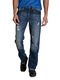
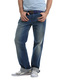
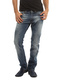
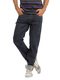
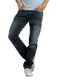
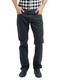
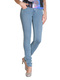
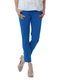
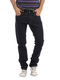
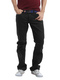
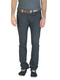
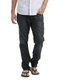
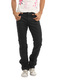
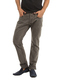
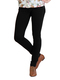
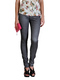
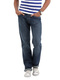
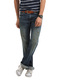
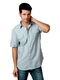
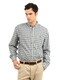

In [13]:
# Example query
query = "dark blue french connection jeans for men"
results = search_elasticsearch(query, weights=[1, 0, 0], top_k=20)

print_results(results)
# display the images
display_result([id_to_image[int(id)] for id, product, score in results])

31507: Flying Machine Men Washed Blue Jeans: 0.6658823
11868: Locomotive Men Radley Blue Jeans: 0.6647983
36791: Wrangler Men Blue Skanders Jeans: 0.66443896
17651: Spykar Men Washed Navy Blue Jeans: 0.6643074
14842: Locomotive Men Race Blue Jeans: 0.66360813
40484: French Connection Men Blue Jeans: 0.6630015
21396: Denizen Men Blue Jeans: 0.6628761
12821: Spykar Men Actif Fit Low Waist Blue Jeans: 0.6625465
38402: Locomotive Men Cael Blue Jeans: 0.6622854
39428: Flying Machine Men Washed Blue Jeans: 0.6617337
14458: Locomotive Men Ian Blue Jeans: 0.66149896
37925: Locomotive Men Cam Blue Jeans: 0.6611629
2278: Gini and Jony Girls Woven Navy Blue Jeans: 0.66083634
43403: Gini and Jony Girls Woven Navy Blue Jeans: 0.66083634
28375: United Colors of Benetton Boys Blue Slim Fit Jeans: 0.66059154
19230: Locomotive Men Washed Blue Jeans: 0.660518
3489: Peter England Men Blue Party Jeans: 0.66049516
25690: French Connection Men Navy Blue Jeans: 0.66038686
11054: Locomotive Men Rafe Blue Jean


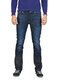
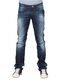
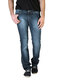
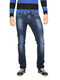
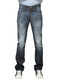
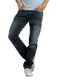
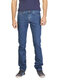
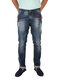
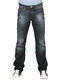
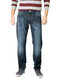
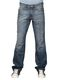
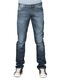
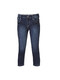
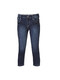
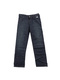
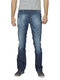
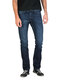
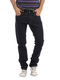
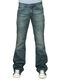
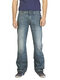

In [10]:
# Example query
query = "dark blue french connection jeans for men"
results = search_elasticsearch(query, weights=[0, 1, 0], top_k=20)

print_results(results)
# display the images
display_result([id_to_image[int(id)] for id, product, score in results])

25690: French Connection Men Navy Blue Jeans: 0.9742628
5371: French Connection Men Black Jeans: 0.9565757
7885: French Connection Men Black Jeans: 0.9565757
8133: French Connection Men Black Jeans: 0.9565757
22300: French Connection Men Black Jeans: 0.9565757
20801: Denizen Men Navy Blue Jeans: 0.9492053
39575: Denizen Men Navy Blue Jeans: 0.9492053
41413: Denizen Men Navy Blue Jeans: 0.9492053
1662: French Connection Men Blue Jeans: 0.9438381
22690: French Connection Men Blue Jeans: 0.9438381
26157: French Connection Men Blue Jeans: 0.9438381
40484: French Connection Men Blue Jeans: 0.9438381
43679: French Connection Men Blue Jeans: 0.9438381
4653: French Connection Men Blue Jeans: 0.94383806
19399: French Connection Navy Washed Skinny Stretchable Jeans: 0.94283164
42769: French Connection Men Grey Jeans: 0.9426926
25318: French Connection Men Blue paint Stained Regular Fit Jeans: 0.9410797
9496: Denizen Men Blue Jeans: 0.93975186
13764: Denizen Men Blue Jeans: 0.93975186
15425: Deni


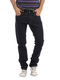
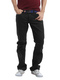
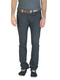
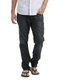
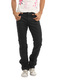
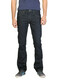
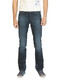
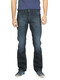
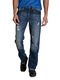
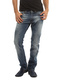
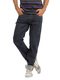
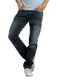
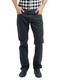
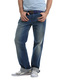
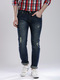
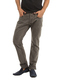
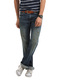
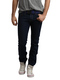
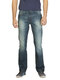
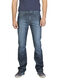

In [11]:
# Example query
query = "dark blue french connection jeans for men"
results = search_elasticsearch(query, weights=[0, 0, 1], top_k=20)

print_results(results)
# display the images
display_result([id_to_image[int(id)] for id, product, score in results])

25690: French Connection Men Navy Blue Jeans: 0.82663685
40484: French Connection Men Blue Jeans: 0.8134198
26157: French Connection Men Blue Jeans: 0.81179744
7885: French Connection Men Black Jeans: 0.81100535
4653: French Connection Men Blue Jeans: 0.8100575
8133: French Connection Men Black Jeans: 0.80985963
22690: French Connection Men Blue Jeans: 0.8083686
22300: French Connection Men Black Jeans: 0.8080966
1662: French Connection Men Blue Jeans: 0.8080206
41413: Denizen Men Navy Blue Jeans: 0.8076646
43679: French Connection Men Blue Jeans: 0.80656385
5371: French Connection Men Black Jeans: 0.80603635
21396: Denizen Men Blue Jeans: 0.8059462
25318: French Connection Men Blue paint Stained Regular Fit Jeans: 0.8053343
20801: Denizen Men Navy Blue Jeans: 0.8052554
39575: Denizen Men Navy Blue Jeans: 0.80498177
24408: Denizen Men Blue Jeans: 0.804465
19399: French Connection Navy Washed Skinny Stretchable Jeans: 0.804236
15425: Denizen Men Blue Jeans: 0.8041865
9496: Denizen Men B


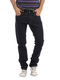
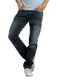
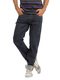
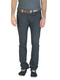
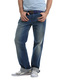
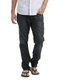
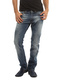
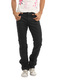
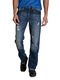
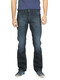
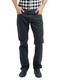
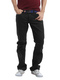
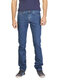
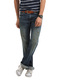
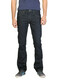
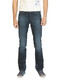
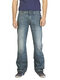
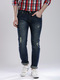
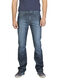
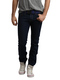

In [12]:
# Example query
query = "dark blue french connection jeans for men"
results = search_elasticsearch(query, weights=[0.01, 0.5, 0.5], top_k=20)

print_results(results)
# display the images
display_result([id_to_image[int(id)] for id, product, score in results])

20068: French Connection Women Blue Jeans: 0.8102935
28065: French Connection Women Blue Jeans: 0.80258644
14755: Spykar Women Light Blue Jeans: 0.8008008
11492: Spykar Women Light Blue Jeans: 0.79950327
11272: Denizen Women Blue Jeans: 0.7990567
14949: Denizen Women Blue Jeans: 0.7989004
27565: Elle Women Light Blue Jeans: 0.79886174
35054: Denizen Women Blue Jeans: 0.7986997
373: Denizen Women Blue Jeans: 0.79752284
14800: Denizen Women Blue Jeans: 0.7974676
3582: Denizen Women Blue Jeans: 0.79708326
7059: Elle Women Blue Jeans: 0.7964848
26372: Spykar Women Blue Washed Jeans: 0.79508483
22493: Kraus Jeans Women Blue Jeans: 0.79452413
4565: Spykar Women Blue Washed Jeans: 0.7944913
9720: Flying Machine Women Midrise Blue Jeans: 0.7938595
12891: Flying Machine Women Lowrise Blue Jeans: 0.7937935
13696: Kraus Jeans Women Blue Jeans: 0.79366857
34676: Denizen Women Blue Jeans: 0.7929505
40484: French Connection Men Blue Jeans: 0.792381



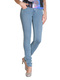
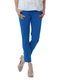
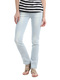
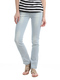
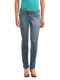
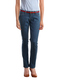
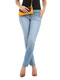
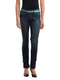
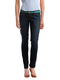
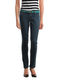
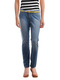
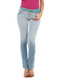
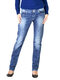
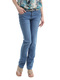
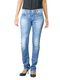
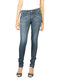
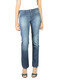
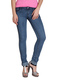
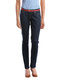
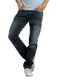

In [13]:
# Example query
query = "light blue french connection jeans for women"
results = search_elasticsearch(query, weights=[0.01, 0.5, 0.5], top_k=20)

print_results(results)
# display the images
display_result([id_to_image[int(id)] for id, product, score in results])

39272: Spykar Men Stripes Yellow Shirts: 0.7977329
32893: Classic Polo Men Stripes Yellow Polo T-Shirt: 0.7973041
11287: Basics Men Yellow Striped T-shirt: 0.796074
27575: Gini and Jony Boys Striped Yellow T-Shirt: 0.7898578
40534: Gini and Jony Boys Striped Yellow T-Shirt: 0.7898578
42997: Basics Men Yellow Striped Polo T-shirt: 0.789736
39813: Arrow Woman Light Yellow Striped Shirt: 0.78729737
8904: Basics Men Yellow Striped Polo T-shirt: 0.7854495
26500: Scullers Men Stripes Yellow Sweaters: 0.784893
40848: Classic Polo Men Stripes Mustard Polo T-Shirt: 0.78384006
17896: Basics Men Yellow Striped Polo T-shirt: 0.78372145
15514: Nike Men Black & Yellow Striped T-shirt: 0.7822078
18727: Proline Mustard Yellow Polo T-shirt: 0.7813154
15188: John Players Men Stripes Yellow Shirt: 0.7767437
2884: Proline Men Mustard Yellow T-shirt: 0.77420914
33023: John Miller Men Striped Yellow Shirt: 0.77364564
43140: Proline Men Grey & Yellow Striped Polo T-shirt: 0.7718787
6837: Levis Men Stripes Ye


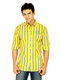
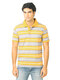
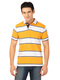
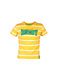
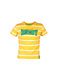
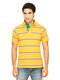
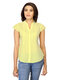
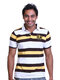
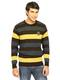
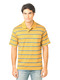
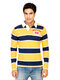
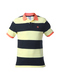
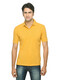
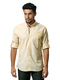
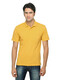
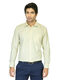
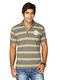
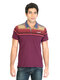
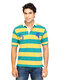
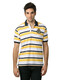

In [14]:
# Example query
query = " yellow t-shirt with stripes"
results = search_elasticsearch(query, weights=[0.01, 0.5, 0.5], top_k=20)

print_results(results)
# display the images
display_result([id_to_image[int(id)] for id, product, score in results])

23250: Murcia Women Hths Brown Handbags: 0.748283
36336: Murcia Women Hddcs Brown Handbags: 0.7382619
43550: Murcia Women Rubena Brown Handbags: 0.73748803
20279: Murcia Women Kkhh Red Handbags: 0.7372366
40655: Lino Perros Women Brown Handbag: 0.737195
628: Murcia Women Hahk Brown Handbags: 0.73708427
761: Baggit Brown Handbag: 0.73688996
4531: Murcia Women Rubena Brown Handbags: 0.7356958
32004: Lino Perros Women Orange Handbag: 0.73563313
4690: Murcia Women Multi Handbag: 0.7346615
4871: Kiara Women Brown Handbags: 0.73462987
17787: Murcia Women Brown Leather Bag: 0.73439956
15579: Baggit Women Brown Handbag: 0.734112
22617: Murcia Women Kkhh Grey Handbags: 0.7340419
28206: Peperone Brown Handbag: 0.7337153
10376: Murcia Women  Marron Handbag: 0.7335085
42230: Murcia Women Hahk Brown Handbags: 0.73315585
17245: Murcia Women Peach Handbag: 0.7326642
1922: Lino Perros Women Casual Handbag: 0.7325472
3991: Murcia Women Brown With Stitch Bag: 0.73240733



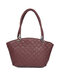
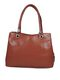
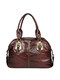
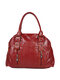
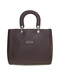
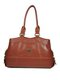
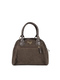
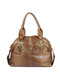
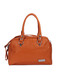
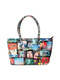
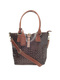
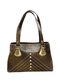
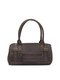
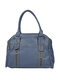
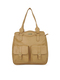
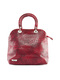
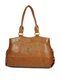
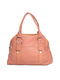
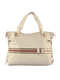
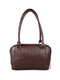

In [15]:
# Example query
query = "birkin hermes"
results = search_elasticsearch(query, weights=[0.01, 0.5, 0.5], top_k=20)

print_results(results)
# display the images
display_result([id_to_image[int(id)] for id, product, score in results])

## image search


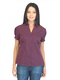

In [18]:
def image_search(image, top_k=10):
    image_vector = model.encode(image).tolist()
    image_vector_query = {
        "size": top_k,
        "query": {
            "script_score": {
                "query": {"match_all": {}},
                "script": {
                    "source": "(cosineSimilarity(params.query_vector, 'image_vector') + 1.0) / 2.0",
                    "params": {"query_vector": image_vector},
                },
            }
        },
    }
    response = es.search(index=index_name, body=image_vector_query)
    results = [
        (hit["_id"], hit["_source"]["productDisplayName"], hit["_score"])
        for hit in response["hits"]["hits"]
    ]
    return results


def display_image(image):
    b = BytesIO()
    image.save(b, format="png")
    return HTML(
        data=f"""
        <figure style="margin: 5px !important;">
          <img src="data:image/png;base64,{b64encode(b.getvalue()).decode("utf-8")}" style="width: 90px; height: 120px" >
        </figure>
    """
    )


image = images[7]
display_image(image)


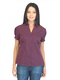
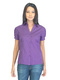
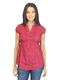
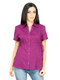
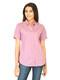
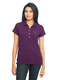
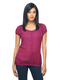
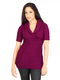
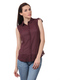
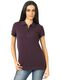

In [19]:
results = image_search(image, top_k=10)
display_result([id_to_image[int(id)] for id, product, score in results])

## image and query search

In [20]:
def image_and_query_search(image, query, top_k=10, color_filter=None):
    # filter by query and color first and sort by score
    image_vector = model.encode(image).tolist()
    text_vector = model.encode(query).tolist()
    query_filter = {
        "size": top_k,
        "min_score": 0.5,
        "query": {
            "function_score": {
                "query": {
                    "bool": {
                        "must": [
                            {
                                "match": {
                                    "productDisplayName": {
                                        "query": query,
                                        "minimum_should_match": "30%",
                                    }
                                }
                            }
                        ],
                        "filter": (
                            [
                                {"term": {"metadata.baseColour": color_filter}},
                            ]
                            if color_filter is not None
                            else []
                        ),
                    }
                },
                "functions": [
                    {
                        # Text similarity filter (only apply if similarity >= 0.5)
                        "script_score": {
                            "script": {
                                "source": """
                                    double similarity = (cosineSimilarity(params.query_vector, 'text_vector') + 1.0) / 2.0;
                                    return similarity >= 0.87 ? similarity * 0.2 : 0;
                                """,
                                "params": {"query_vector": text_vector},
                            }
                        }
                    },
                    {
                        # Image similarity scoring
                        "script_score": {
                            "script": {
                                "source": """
                                    double similarity = (cosineSimilarity(params.query_vector, 'image_vector') + 1.0) / 2.0;
                                    return similarity >= 0.88 ? similarity * 0.8 : 0;
                                """,
                                "params": {"query_vector": image_vector},
                            }
                        }
                    },
                ],
                "score_mode": "sum",  # Ensures text similarity acts as a filter, not a scoring factor
                "boost_mode": "replace",
            }
        },
    }

    response = es.search(index=index_name, body=query_filter)
    results = [
        (hit["_id"], hit["_source"]["productDisplayName"], hit["_score"])
        for hit in response["hits"]["hits"]
    ]
    return results


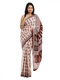

In [21]:
image = images[300]
display_image(image)

25449: FNF Cream & Pink Evening Wear Sari: 0.78256965
34815: FNF Red & White Evening Wear Sari: 0.7767137
43827: FNF Multicoloured Evening Wear Sari: 0.77570575
1583: FNF Pink & Yellow Printed Evening Wear Sari: 0.7739746
27598: FNF Purple Evening Wear Sari: 0.7736061
19915: FNF Red & Orange Evening Wear Sari: 0.7730415
5056: FNF Green Printed Evening Wear Sari: 0.772708
23355: FNF Red & Blue Evening Wear Sari: 0.77213967
22365: FNF Purple Printed Evening Wear Sari: 0.77130216
14895: FNF Red & Black Evening Wear Sari: 0.7712533
2351: FNF Purple Evening Wear Sari: 0.769577
4685: FNF Purple Printed Evening Wear Sari: 0.7690468
4464: FNF Mustard & Purple Evening Wear Sari: 0.7687586
26091: FNF Pink & Purple Evening Wear Sari: 0.76808643
23516: FNF Brown Collection for Wedding Wear Sari: 0.7679222
20381: FNF Yellow Evening Wear Sari: 0.76715404
16657: FNF Green Printed Evening Wear Sari: 0.76659924
23252: FNF Green Printed Evening Wear Sari: 0.766414
23011: FNF Red Printed Evening Wear Sar


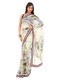
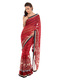
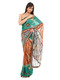
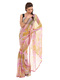
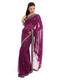
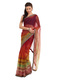
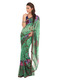
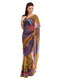
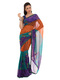
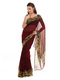
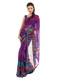
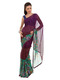
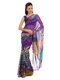
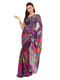
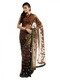
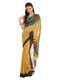
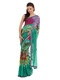
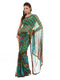
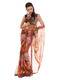
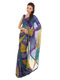

In [22]:
results = image_and_query_search(
    image,
    "soft top wear",
    top_k=20,
    # color_filter="purple"
)
print_results(results)
display_result([id_to_image[int(id)] for id, product, score in results])

23277: Prafful Purple Sari: 0.9465752
20741: Scullers For Her Women Purple Top: 0.92502946
11649: ONLY Women Purple Tunic: 0.92295104
21135: ONLY Women Pink Top: 0.9192146
31965: Avirate Women Purple Dress: 0.9179581
35080: Sepia Women Purple Top: 0.9176207
24280: s.Oliver Women Solid Purple Top: 0.9158142
43727: Arrow Woman Lavender Top: 0.91417605
12153: Arrow Woman Rima Purple Dress: 0.9133701
38213: ONLY Women Purple Tunic: 0.913128
38492: ONLY Women Purple Dress: 0.91295534
35027: Sepia Women Purple Top: 0.9127507
35546: Sepia Women Purple Top: 0.91268045
32148: Mineral Women Purple Dress: 0.91121906
38052: French Connection Women Purple Dress: 0.91074616
20637: Arrow Woman Lavender Top: 0.9103938
22393: s.Oliver Women Solid Lavender Top: 0.91035473
11167: ONLY Women Purple Top: 0.90969217
22548: Arrow Woman Eleana Purple Top: 0.9088227
11155: Elle Color Clash Purple Dress: 0.90825534



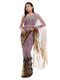
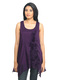
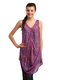
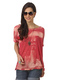
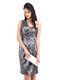
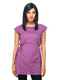
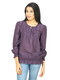
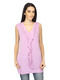
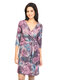
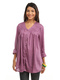
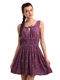
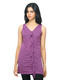
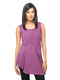
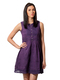
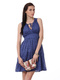
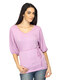
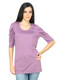
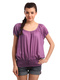
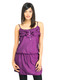
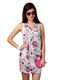

In [23]:
results = image_and_query_search(
    image,
    "soft purple top wear",
    top_k=20,
    # color_filter="purple"
)
print_results(results)
display_result([id_to_image[int(id)] for id, product, score in results])

23277: Prafful Purple Sari: 0.9465752
20741: Scullers For Her Women Purple Top: 0.92502946
11649: ONLY Women Purple Tunic: 0.92295104
31965: Avirate Women Purple Dress: 0.9179581
35080: Sepia Women Purple Top: 0.9176207
24280: s.Oliver Women Solid Purple Top: 0.9158142
12153: Arrow Woman Rima Purple Dress: 0.9133701
38213: ONLY Women Purple Tunic: 0.913128
38492: ONLY Women Purple Dress: 0.91295534
35027: Sepia Women Purple Top: 0.9127507
35546: Sepia Women Purple Top: 0.91268045
32148: Mineral Women Purple Dress: 0.91121906
38052: French Connection Women Purple Dress: 0.91074616
11167: ONLY Women Purple Top: 0.90969217
22548: Arrow Woman Eleana Purple Top: 0.9088227
8994: Scullers For Her Women Solid Purple Tunic: 0.90655506
14151: Spykar Women Purple Top: 0.9042714
7407: Arrow Woman Victoria Purple Top: 0.9032076
15527: Jealous 21 Women Solid Purple Tops: 0.9027496
3260: Sepia Women Purple Top: 0.90188617



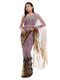
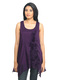
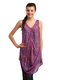
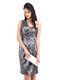
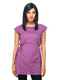
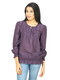
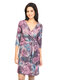
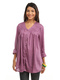
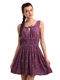
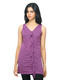
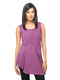
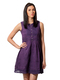
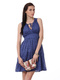
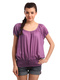
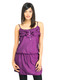
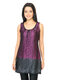
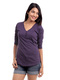
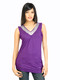
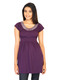
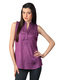

In [24]:
results = image_and_query_search(
    image, "soft purple top wear", top_k=20, color_filter="purple"
)
print_results(results)
display_result([id_to_image[int(id)] for id, product, score in results])


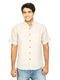

In [25]:
image = images[36256]
display_image(image)

8952: Wills Lifestyle Men Check Green Shirt: 0.9574796
36127: John Players Men Check Green Shirt: 0.9547386
33946: Mother Earth Men Green Shirt: 0.9504844
36585: John Players Men Check Green Shirt: 0.94863814
27912: French Connection Men Green Shirt: 0.94811124
17678: Arrow Men Green Shirt: 0.94628966
8643: Turtle Men Check Green Shirt: 0.94562924
10615: United Colors of Benetton Men Check Green Shirts: 0.9434283
18979: Lee Men Check Green Shirts: 0.94225186
35682: Spykar Men Green Sweaters: 0.94173676
23775: Spykar Men Green Shirt: 0.9409654
32721: Wills Lifestyle Men Check Green Shirt: 0.93740946
21992: Lee Men Check Green Shirts: 0.9371257
26475: John Players Men Check Green Shirt: 0.9364568
41842: Denizen Men Check Green Shirt: 0.9361981
3429: John Players Men Check Green Shirt: 0.93568957
32617: Turtle Men Check Green Shirt: 0.935439
11402: Lee Men Check Green Shirts: 0.9340292
1188: Flying Machine Men HS Green Shirts: 0.93399715
29214: Turtle Men Check Green Shirt: 0.9339501



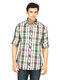
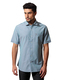
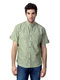
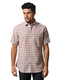
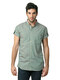
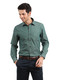
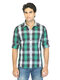
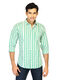
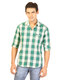
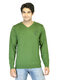
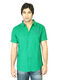
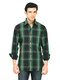
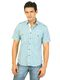
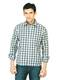
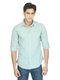
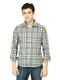
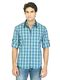
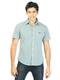
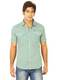
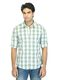

In [26]:
results = image_and_query_search(image, "green topwear", top_k=20, color_filter="green")
print_results(results)
display_result([id_to_image[int(id)] for id, product, score in results])